In [59]:
def retrieve_data(file_path):
    with open(file_path, 'r') as file:
        data = file.readlines()

    # Extract position data and start
    start = None
    positions = []
    for line in data:
        if "start" in line:
            split_line = line.split("->")[1].split("|")
            translation_data = [float(x) for x in split_line[0].split(":")[1].strip().strip("(").strip(")").split(",")]
            rotation_data = [float(x) for x in split_line[1].split(":")[1].strip().strip("(").strip(")").split(",")]
            start = {
                "translation": translation_data,
                "rotation": rotation_data,
            }
            continue
        split_line = line.split(",")
        x = float(split_line[0].split(":")[1])
        y = float(split_line[1].split(":")[1])
        positions.append((x, y))

    return start, positions


In [60]:
start, positions = retrieve_data("Data/robot_position_(1.8, 6.3, 0.05)_1.txt")

In [61]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def orient_positions(start, positions):
    # If start data exists, offset all the points by the translation
    # Then rotate the points by the rotation
    if start:
        # Use Webot starting translation and rotation data
        translation = start['translation']
        axis = start['rotation'][:3]
        angle = start['rotation'][3]

        # normalize the axis
        axis = np.array(axis) / np.linalg.norm(axis)

        # Create a rotation matrix from the axis and angle
        rotation_vector = axis * angle
        rotation = R.from_rotvec(rotation_vector)

        # Offset translation
        positions = [
            (
                (x + translation[0]),
                (y + translation[1]),
                0
            )
            for x, y in positions
        ]

        positions = np.array(positions)

        rotated_positions = rotation.apply(positions)

        # Apply 2D rotation matrix for the angle
        # cos_angle = np.cos(rotation_angle)
        # sin_angle = np.sin(rotation_angle)
        
        # positions = [
        #     (
        #         x * cos_angle - y * sin_angle,
        #         x * sin_angle + y * cos_angle
        #     )
        #     for x, y in positions
        # ]

        positions = [
            (
                x,
                y
            )
            for x, y, z in rotated_positions
        ]

        return positions
    return positions

In [62]:
augmented_positions = orient_positions(start, positions)

In [63]:
augmented_positions[:5]

[(6.301431390549879, -1.7949825709996825),
 (6.465615413561713, -2.1650950216668154),
 (6.99972697483998, -2.2606783401549047),
 (7.54370614593861, -2.4757238807266746),
 (7.621467060286947, -3.188007067496852)]

In [64]:
import matplotlib.pyplot as plt
import numpy as np

def map_positions(data):
    data = np.array(data)
    plt.plot(data[:, 0], data[:, 1])
    # Label Point 0 as "Start"
    plt.text(data[0, 0], data[0, 1], "Start", fontsize=12, verticalalignment='bottom')
    # Label Last Point as "End"
    plt.text(data[-1, 0], data[-1, 1], "End", fontsize=12, verticalalignment='bottom')
    plt.show()

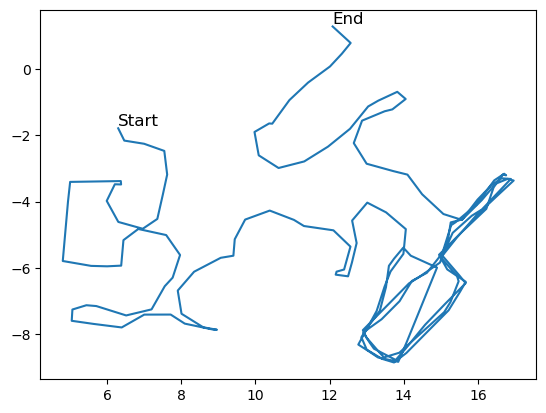

In [65]:
map_positions(augmented_positions)

In [66]:
min_x = min([x for x, y in augmented_positions])
max_x = max([x for x, y in augmented_positions])
min_y = min([y for x, y in augmented_positions])
max_y = max([y for x, y in augmented_positions])

bottom_left = (min_x, min_y)
top_right = (max_x, max_y)

print(bottom_left)
print(top_right)


(4.806975631269097, -8.84588658961891)
(16.961884008287456, 1.2708400319099942)


In [67]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

map_image_path = "apartment.jpg"
img = plt.imread(map_image_path)

def overlayed_map_positions(data):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Display the background image
    # extent specifies the left, right, bottom, and top sides of the image.
    # Ensure that the extent covers the range of the data appropriately.
    # ax.imshow(img, extent=[data[:, 0].min(), data[:, 0].max(), data[:, 1].min(), data[:, 1].max()], aspect='auto')
    bottom_left = (-1, -.5)
    top_right = (11.5, 10)

    ax.imshow(img, extent=[bottom_left[0], top_right[0], bottom_left[1], top_right[1]], aspect='auto')

    # Convert your data to a NumPy array
    data = np.array(data)

    # Create a color gradient for the path
    points = np.array([data[:, 0], data[:, 1]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Normalize colors over the length of the data
    norm = Normalize(vmin=0, vmax=len(data)-1)
    colors = plt.cm.viridis(norm(np.arange(len(data))))

    # Create a line collection with gradient
    lc = LineCollection(segments, cmap='viridis', norm=norm, linewidth=2)
    lc.set_array(np.arange(len(data)))

    # Add the line collection to the axis
    line = ax.add_collection(lc)

    # Label the start point
    ax.text(data[0, 0], data[0, 1], "Start", fontsize=12, verticalalignment='bottom', color="red")

    # Label the end point
    ax.text(data[-1, 0], data[-1, 1], "End", fontsize=12, verticalalignment='bottom', color="red")

    # Add color bar to show the gradient scale
    cbar = plt.colorbar(line, ax=ax)
    cbar.set_label("Path Progression (Older to Newer Points)")

    # Set limits based on the data
    ax.set_xlim([min(bottom_left[0], data[:, 0].min()), max(top_right[0], data[:, 0].max())])
    ax.set_ylim([min(bottom_left[1], data[:, 1].min()), max(top_right[1], data[:, 1].max())])

    # Display the plot
    plt.show()


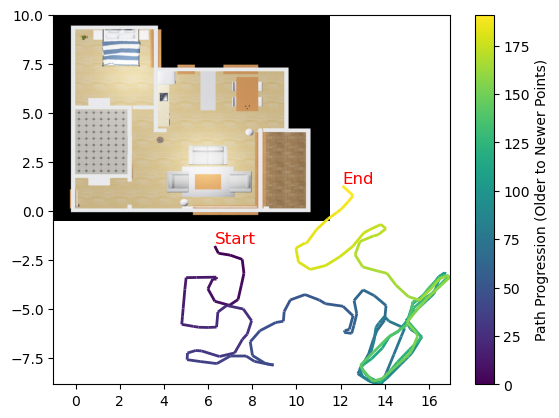

In [68]:
overlayed_map_positions(augmented_positions)

In [69]:
filename_map = {
    "(7.6, 3.5, 0.05)": "Zone 1",
    "(5.2, 6.0, 0.05)": "Zone 2",
    "(1.8, 6.3, 0.05)": "Zone 3",
    "(0.96, 0.492, 0.05)": "Zone 4",
}


In [70]:
# Grab all the data files
import os

data_files = os.listdir("Data")

# Sort the data files by the number in the file name
zone_files = {
    zone_name: sorted([
        file for file in data_files if area_config in file
    ], key=lambda x: int(x.split("_")[-1].split(".")[0]))
    for area_config, zone_name in filename_map.items()
}


In [71]:
zone_files

{'Zone 1': ['robot_position_(7.6, 3.5, 0.05)_1.txt',
  'robot_position_(7.6, 3.5, 0.05)_2.txt',
  'robot_position_(7.6, 3.5, 0.05)_3.txt',
  'robot_position_(7.6, 3.5, 0.05)_4.txt',
  'robot_position_(7.6, 3.5, 0.05)_5.txt'],
 'Zone 2': ['robot_position_(5.2, 6.0, 0.05)_1.txt',
  'robot_position_(5.2, 6.0, 0.05)_2.txt',
  'robot_position_(5.2, 6.0, 0.05)_3.txt',
  'robot_position_(5.2, 6.0, 0.05)_4.txt',
  'robot_position_(5.2, 6.0, 0.05)_5.txt'],
 'Zone 3': ['robot_position_(1.8, 6.3, 0.05)_1.txt',
  'robot_position_(1.8, 6.3, 0.05)_2.txt',
  'robot_position_(1.8, 6.3, 0.05)_3.txt',
  'robot_position_(1.8, 6.3, 0.05)_4.txt',
  'robot_position_(1.8, 6.3, 0.05)_5.txt'],
 'Zone 4': ['robot_position_(0.96, 0.492, 0.05)_1.txt',
  'robot_position_(0.96, 0.492, 0.05)_2.txt',
  'robot_position_(0.96, 0.492, 0.05)_3.txt',
  'robot_position_(0.96, 0.492, 0.05)_4.txt',
  'robot_position_(0.96, 0.492, 0.05)_5.txt']}

In [72]:
zone_data = {
    zone_name: [orient_positions(*retrieve_data(f"Data/{file}")) for file in files]
    for zone_name, files in zone_files.items()
}

In [73]:
import numpy as np

def calculate_path_length(data):
    return np.sum([
        np.linalg.norm(np.array(data[i]) - np.array(data[i+1]))
        for i in range(len(data) - 1)
    ])

def calculate_max_distance(data):
    # Calculate the max distance from start to all other points
    start = np.array(data[0])
    distances = [
        np.linalg.norm(np.array(point) - start)
        for point in data
    ]
    return max(distances)

def calculate_path_stats(data):
    return {
        "path_length": calculate_path_length(data),
        "max_distance": calculate_max_distance(data)
    }

zone_stats = {
    zone_name: [calculate_path_stats(data) for data in zone_data[zone_name]]
    for zone_name in zone_data
}

In [74]:
zone_stats

{'Zone 1': [{'path_length': 99.33882459160024,
   'max_distance': 10.022901122164823},
  {'path_length': 103.26884831965549, 'max_distance': 11.071614248110784},
  {'path_length': 68.88974441979832, 'max_distance': 7.270763476587419},
  {'path_length': 77.57647670960303, 'max_distance': 11.435628149726089},
  {'path_length': 196.42826805559082, 'max_distance': 14.692558621559643}],
 'Zone 2': [{'path_length': 76.0684823690834,
   'max_distance': 7.536954391908876},
  {'path_length': 79.31981487676774, 'max_distance': 7.123253897456327},
  {'path_length': 107.44112296030258, 'max_distance': 7.287256869027278},
  {'path_length': 101.64252757373804, 'max_distance': 9.704256304391071},
  {'path_length': 173.71518849969428, 'max_distance': 7.386423256471574}],
 'Zone 3': [{'path_length': 104.04040578175238,
   'max_distance': 10.775870198960906},
  {'path_length': 85.0564362028016, 'max_distance': 10.652264569807294},
  {'path_length': 66.78372723900368, 'max_distance': 10.21021830982761},


In [75]:
with open("zone_stats.csv", "w") as file:
    file.write("Zone,Trial,Path Length,Max Distance\n")
    for zone_name, stats in zone_stats.items():
        for i, stat in enumerate(stats):
            file.write(f"{zone_name},{i+1},{stat['path_length']},{stat['max_distance']}\n")

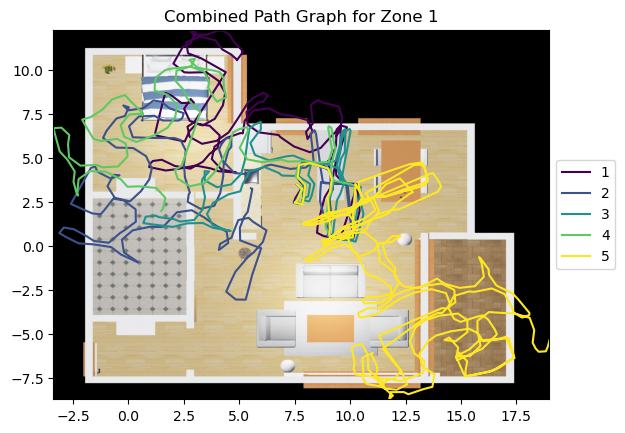

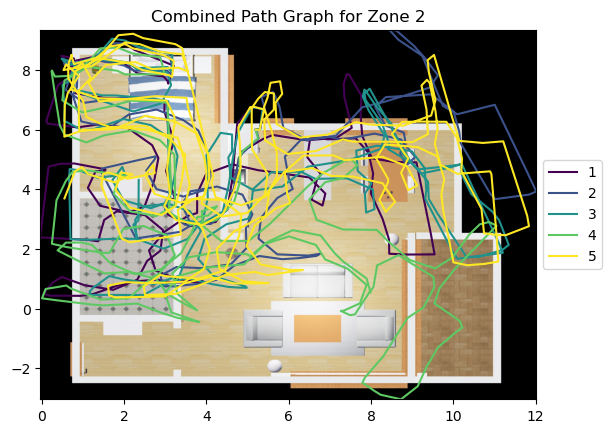

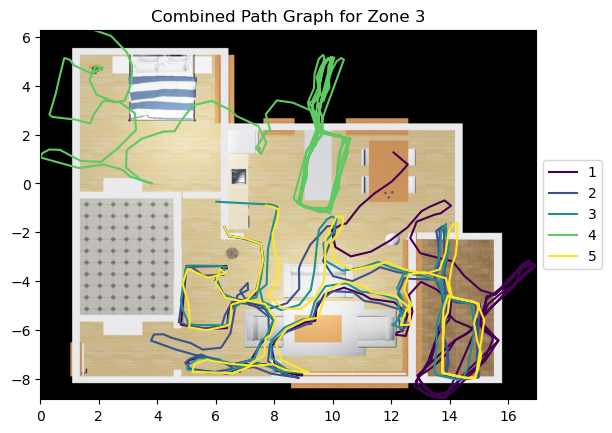

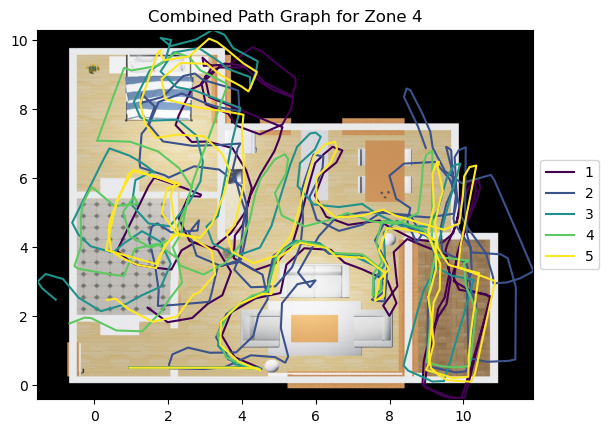

In [76]:
def combined_map_graphs(zone_data):
    # Check if the data is empty
    if not zone_data:
        print(f"No data to plot for {zone_name}")
        return

    # Create a graph that has all the paths for that zone
    # Each path has a different color

    min_x = min([x for x, y in np.concatenate(zone_data)])
    max_x = max([x for x, y in np.concatenate(zone_data)])
    min_y = min([y for x, y in np.concatenate(zone_data)])
    max_y = max([y for x, y in np.concatenate(zone_data)])

    bottom_left = (min_x, min_y)
    top_right = (max_x, max_y)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Display the background image
    ax.imshow(img, extent=[bottom_left[0], top_right[0], bottom_left[1], top_right[1]], aspect='auto')

    # Create a color for each path
    colors = plt.cm.viridis(np.linspace(0, 1, len(zone_data)))

    for i, data in enumerate(zone_data):
        data = np.array(data)

        # select a color
        color = colors[i]

        # add the line to the axis with the color
        ax.plot(data[:, 0], data[:, 1], color=color)
        
    # Add a legend to the plot outside of the plot
    ax.legend([f"{i+1}" for i in range(len(zone_data))] , loc='center left', bbox_to_anchor=(1, 0.5))

    # Set limits based on the data
    ax.set_xlim([min(bottom_left[0], data[:, 0].min()), max(top_right[0], data[:, 0].max())])
    ax.set_ylim([min(bottom_left[1], data[:, 1].min()), max(top_right[1], data[:, 1].max())])

    # Add a title to the plot
    ax.set_title(f"Combined Path Graph for {zone_name}")

    # Display the plot
    plt.show()

    # Save the plot to a file
    fig.savefig(f"{zone_name}_combined_map.png")

for zone_name, data in zone_data.items():
    combined_map_graphs(data)
# combined_map_graphs(zone_data["Zone 2"])